In [1]:
#Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Load Dataset
df1 = pd.read_csv('./swiss.csv')
df1.head()

Location  Fertility  Agriculture  Examination  Education  Catholic  \
0    Courtelary       80.2         17.0           15         12      9.96   
1      Delemont       83.1         45.1            6          9     84.84   
2  Franches-Mnt       92.5         39.7            5          5     93.40   
3       Moutier       85.8         36.5           12          7     33.77   
4    Neuveville       76.9         43.5           17         15      5.16   

   InfantMortality  
0             22.2  
1             22.2  
2             20.2  
3             20.3  
4             20.6

In [3]:
#Dataset Attributes
df1 = df1.drop('Location',axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 6 columns):
Fertility          47 non-null float64
Agriculture        47 non-null float64
Examination        47 non-null int64
Education          47 non-null int64
Catholic           47 non-null float64
InfantMortality    47 non-null float64
dtypes: float64(4), int64(2)
memory usage: 2.3 KB


In [4]:
#Summary of N/A Values
df1.isnull().sum()

Fertility          0
Agriculture        0
Examination        0
Education          0
Catholic           0
InfantMortality    0
dtype: int64

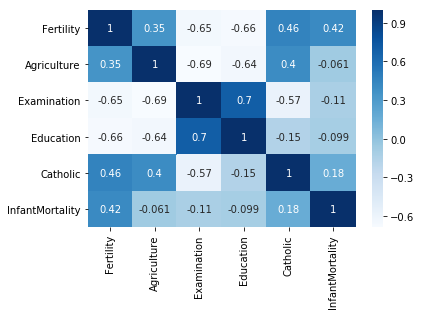

In [5]:
#Visualization of Correlations
import seaborn as sns
sns.heatmap(df1.corr(),annot=True,cmap="Blues")

In [6]:
#Identify Correlated Columns
def correlation(dataset,threshold):
    col_corr=set() # set will contains unique values.
    corr_matrix=dataset.corr() #finding the correlation between columns.
    for i in range(len(corr_matrix.columns)): #number of columns
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking the correlation between columns.
                colName=corr_matrix.columns[i] #getting the column name
                col_corr.add(colName) #adding the correlated column name higher than threshold value.
    return col_corr #returning set of column names
col=correlation(df1.drop('InfantMortality',axis=1),0.8)
print('Correlated columns:',col)    

Correlated columns: set()


In [7]:
#Define x and y variable
x = df1.drop('InfantMortality',axis=1).values
y = df1['InfantMortality'].values

In [8]:
#Train dataset using 20% test set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.fit_transform(x_test)

x_2 = sc.fit_transform(x)

In [9]:
#Load and Create Linear Regression library
from sklearn.linear_model import LinearRegression
model = [LinearRegression()]

In [10]:
#Create Model Comparison
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

#Scoring Parameters
scoring = {'MAE':'neg_mean_absolute_error',
           'MSE':'neg_mean_squared_error'}

#Model Creation
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for alg in model:
    
    #Linear Model
    predicted = alg.fit(x_train2, y_train).predict(x_test2)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    
    #K-Fold CV
    kfcv = alg.fit(x_train2, y_train)
    kf = KFold(n_splits=10, shuffle=True, random_state=100)
    KFcv = cross_validate(kfcv, x_2, y, scoring=scoring,
                         cv=kf)
    
    #Repeated K-Fold CV
    rkfcv = alg.fit(x_train2, y_train)
    rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    rKFcv = cross_validate(rkfcv, x_2, y, scoring=scoring,
                         cv=rkf)
    
    #LOOCV
    loomodel=alg.fit(x_train2, y_train)
    loo = LeaveOneOut()
    loocv = cross_validate(loomodel, x_2, y, scoring=scoring,
                         cv=loo)
    
    #Shuffle-Split
    rsmodel=alg.fit(x_train2, y_train)
    rs = ShuffleSplit(n_splits=10, test_size=.20, random_state=100)
    rscv = cross_validate(rsmodel, x_2, y, scoring=scoring,
                         cv=rs)
        
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'Algorithm Name'] = MLA_name
    MLA_compare.loc[row_index, 'Original Model'] = round(rmse_test,2)
    MLA_compare.loc[row_index, 'KFcv Model'] = round(np.sqrt(-KFcv['test_MSE'].mean()),2)
    MLA_compare.loc[row_index, 'rKFcv Model'] = round(np.sqrt(-rKFcv['test_MSE'].mean()),2)
    MLA_compare.loc[row_index, 'Loocv Model'] = round(np.sqrt(-loocv['test_MSE'].mean()),2)
    MLA_compare.loc[row_index, 'ShuffleSplit Model'] = round(np.sqrt(-rscv['test_MSE'].mean()),2)
    
    row_index+=1

MLA_compare

Algorithm Name  Original Model  KFcv Model  rKFcv Model  Loocv Model  \
0  LinearRegression            3.14        2.95         2.88         2.87   

   ShuffleSplit Model  
0                 2.8